In [2]:
import scanpy as sc

In [3]:
import tqdm

In [4]:
import pandas as pd
import cassiopeia as cas

import matplotlib.pyplot as plt

In [5]:
adata = sc.read_h5ad("/Genomics/pritykinlab/share/perturbseq/YangWeissman2022/KPTracer-Data/expression/adata_processed.combined.h5ad")

In [6]:
sc.pp.filter_genes(adata, min_cells=3)

/Genomics/pritykinlab/dillon/software/miniconda/envs/envs/cassiopeia4/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [ ]:
adata.write_h5ad("/Genomics/pritykinlab/dillon/other_studies/YangWeissman2022/all_cells_filtered_genes.h5ad")

In [135]:
adata

AnnData object with n_obs × n_vars = 104197 × 3049
    obs: 'TS_Present', 'RNA_Present', 'MULTI', 'TS_UMI', 'NUM_INTBC', 'Lane', 'Tumor', 'SubTumor', 'ES_clone', 'genotype', 'Aging_time', 'Mouse', 'Aging_Month', 'Batch_Library', 'Batch_Harvest', 'Aging_Time', 'MetFamily', 'lentiBC', 'LentiFiltered', 'is_normal', 'PercentUncut', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'Cluster', 'Cluster-Name'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells'
    uns: 'Batch_Library_colors', 'C_scANVI_colors', 'Cluster-Name_colors', 'Cluster_colors', 'Combined_Clusters_colors', 'Mouse_colors', 'NT_leiden_colors', '_scvi', 'genotype_colors', 'hvg', 'leiden', 'leiden_0.2_colors', 'leiden_0.4_colors', 'leiden_0.6_colors', 'leiden_0.8_colors', 'leiden_1.0_colors', 'leiden_1.5_colors', 'neighb

In [91]:
adata .obs['Tumor']

L10.AAACCTGAGACGCAAC-1    3724_NT_T1
L10.AAACCTGAGAGTTGGC-1    3724_NT_T1
L10.AAACCTGAGCTCCTCT-1    3724_NT_T1
L10.AAACCTGAGGCAGGTT-1    3724_NT_T1
L10.AAACCTGAGTACACCT-1    3724_NT_T1
                             ...    
L9.TTTGTCAGTGCAGACA-1     3724_NT_T1
L9.TTTGTCAGTGCCTGTG-1     3724_NT_T1
L9.TTTGTCATCAGCTTAG-1     3724_NT_T1
L9.TTTGTCATCCGTACAA-1     3724_NT_T1
L9.TTTGTCATCTGTCAAG-1     3724_NT_T1
Name: Tumor, Length: 104197, dtype: category
Categories (133, object): ['3430_NT_T1', '3430_NT_T2', '3430_NT_T3', '3430_NT_T4', ..., '3777_Apc_T4', '3777_Apc_T5', '3777_Apc_T6', 'nan']

## Quality Control Check

In [73]:
import os
import pandas as pd
from cassiopeia.data import CassiopeiaTree  # Replace with the correct import based on your setup

nwk_dir = '/Genomics/pritykinlab/share/perturbseq/YangWeissman2022/KPTracer-Data/trees'

# Assume adata.obs['Tumor'] is a pandas Series with tumor identifiers
# Replace this with your actual adata object
# adata = your_adata_object_here

CBCs = []

# Loop through unique tumor identifiers
for tumor in list(adata.obs['Tumor'].unique()):
    # Construct the filename
    filename = f"{tumor}_tree.nwk"
    
    # Full path to the nwk file
    filepath = os.path.join(nwk_dir, filename)
    
    # Check if the file exists
    if os.path.exists(filepath):
        # Read tree from file
        with open(filepath, 'r') as f:
            tree = f.read()
        
        # Initialize tree
        tree = CassiopeiaTree(tree=tree)
        
        # Add leaves (CBCs) to the list
        print(f"{len(tree.leaves)}")
        for CBC in tree.leaves:
            CBCs.append(CBC)
    else:
        print(f"Warning: File {filename} not found.")

# Check for duplicates
assert len(CBCs) == len(set(CBCs)), "Duplicate CBCs found."

14852
402
215
536
139
550
106
26
98
1356
700
135
213
710
1119
118
306
301
401
453
90
564
93
216
45
78
119
126
124
610
136
116
31
765
1694
649
921
511
202
1124
294
462
173
130
118
322
149
2402
2292
1166
969
1457
2118
347
604
248
246
348
714
3731
312
346
199
226
330
197
204
1226
772
854
658
3404
693


In [74]:
adata_CBCs_set = set(adata.obs_names)

In [75]:
CBCs_also_in_adata = set(CBCs).intersection(adata_CBCs_set)

In [81]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from cassiopeia.data import CassiopeiaTree  # Replace with the correct import based on your setup
from cassiopeia.data import compute_phylogenetic_weight_matrix  # Replace with the correct import based on your setup

# Directory containing the nwk files
nwk_dir = '/Genomics/pritykinlab/share/perturbseq/YangWeissman2022/KPTracer-Data/trees'

# Assuming adata.obs_names is a pandas Index or Series containing CBCs
# adata = your_adata_object_here
adata_CBCs_set = set(adata.obs_names)

# Initialize an empty dictionary to store the nearest neighbors
nearest_neighbors_dict = defaultdict(list)

# Initialize an empty set to store added CBC keys to ensure no duplicates
added_CBCs = set()

# Loop through unique tumor identifiers in the adata object
for tumor in tqdm.tqdm(list(adata.obs['Tumor'].unique())[::-1]):
    filename = f"{tumor}_tree.nwk"
    filepath = os.path.join(nwk_dir, filename)
    
    # Check if the file exists
    if os.path.exists(filepath):
        print(f"Reading {filename}")

        # Read tree from file
        with open(filepath, 'r') as f:
            tree = f.read()
        
        # Initialize tree
        tree = CassiopeiaTree(tree=tree)
        print(f"{len(tree.leaves)}")   
        
        # Compute phylogenetic weight matrix
        df = compute_phylogenetic_weight_matrix(tree)
        for index, row in df.iterrows():
            if index in adata_CBCs_set:  # Check if the CBC is also in the adata object
                assert index not in added_CBCs, f"Duplicated CBC {index} found."  # Assert no duplicates
                
                sorted_neighbors = row.sort_values().index[1:].tolist()  # Exclude the first element to remove the cell itself (distance 0)
                
                # Filter neighbors to accumulate up to 20
                accumulated_neighbors = []
                for neighbor in sorted_neighbors:
                    if len(accumulated_neighbors) < 20:
                        accumulated_neighbors.append(neighbor)
                
                # Assert if fewer than 20 neighbors
                assert len(accumulated_neighbors) == 20, f"Could not find 20 neighbors for {index}"
                
                # Add to dictionary
                nearest_neighbors_dict[index] = accumulated_neighbors

                # Add the CBC to the added_CBCs set
                added_CBCs.add(index)
    else:
        print(f"Warning: File {filename} not found.")

  0%|          | 0/133 [00:00<?, ?it/s]

Reading 3732_Lkb1_T2_tree.nwk
693


  1%|          | 1/133 [00:52<1:55:10, 52.35s/it]

Reading 3732_Lkb1_T1_tree.nwk
3404


  2%|▏         | 2/133 [21:35<27:23:11, 752.61s/it]

Reading 3730_NT_T2_tree.nwk
658


  2%|▏         | 3/133 [22:29<15:40:08, 433.91s/it]

Reading 3726_NT_T2_tree.nwk
854


  3%|▎         | 4/133 [24:09<10:49:00, 301.87s/it]

Reading 3726_NT_T1_tree.nwk
772


  4%|▍         | 5/133 [25:18<7:45:10, 218.05s/it] 

Reading 3730_NT_T1_tree.nwk
1226


  5%|▍         | 6/133 [28:26<7:19:46, 207.77s/it]

Reading 3507_Apc_T2_tree.nwk
204


  5%|▌         | 7/133 [28:31<4:56:59, 141.43s/it]

Reading 3432_NT_T2_tree.nwk
197


  7%|▋         | 9/133 [28:35<2:33:19, 74.19s/it] 

Reading 3433_NT_T2_tree.nwk
330


  8%|▊         | 10/133 [28:48<2:00:02, 58.56s/it]

Reading 3432_NT_T1_tree.nwk
226


  8%|▊         | 11/133 [28:54<1:30:22, 44.45s/it]

Reading 3507_Apc_T1_tree.nwk
199


  9%|▉         | 12/133 [28:59<1:07:33, 33.50s/it]

Reading 3457_Apc_T4_tree.nwk
346


 14%|█▎        | 18/133 [29:12<21:46, 11.36s/it]  

Reading 3508_Apc_T2_tree.nwk
312


 14%|█▍        | 19/133 [29:22<21:24, 11.26s/it]

Reading 3508_Apc_T1_tree.nwk
3731


 16%|█▌        | 21/133 [54:31<7:04:29, 227.40s/it]

Reading 3457_Apc_T1_tree.nwk
714


 17%|█▋        | 23/133 [55:29<5:10:09, 169.17s/it]

Reading 3457_Apc_T3_tree.nwk
348


 19%|█▉        | 25/133 [55:42<3:37:51, 121.04s/it]

Reading 3457_Apc_T2_tree.nwk
246


 20%|██        | 27/133 [55:49<2:32:07, 86.11s/it] 

Reading 3457_Apc_T5_tree.nwk
248


 23%|██▎       | 31/133 [55:56<1:20:41, 47.46s/it]

Reading 3513_NT_T4_tree.nwk
604


 26%|██▌       | 34/133 [56:38<1:00:06, 36.43s/it]

Reading 3513_NT_T5_tree.nwk
347


 26%|██▋       | 35/133 [56:52<54:28, 33.35s/it]  

Reading 3513_NT_T2_tree.nwk
2118


 27%|██▋       | 36/133 [1:05:37<3:02:56, 113.16s/it]

Reading 3513_NT_T3_tree.nwk
1457


 28%|██▊       | 37/133 [1:09:43<3:41:01, 138.14s/it]

Reading 3513_NT_T1_tree.nwk
969


 29%|██▊       | 38/133 [1:11:22<3:25:47, 129.98s/it]

Reading 3434_NT_T2_tree.nwk
1166


 30%|███       | 40/133 [1:14:12<2:54:59, 112.90s/it]

Reading 3434_NT_T3_tree.nwk
2292


 31%|███       | 41/133 [1:23:47<5:23:30, 210.98s/it]

Reading 3434_NT_T1_tree.nwk
2402


 32%|███▏      | 42/133 [1:34:22<7:49:41, 309.69s/it]

Reading 3520_NT_T1_tree.nwk
149


 32%|███▏      | 43/133 [1:34:25<5:49:47, 233.19s/it]

Reading 3435_NT_T3_tree.nwk
322


 33%|███▎      | 44/133 [1:34:41<4:21:20, 176.19s/it]

Reading 3522_Apc_T2_tree.nwk
118


 34%|███▍      | 45/133 [1:34:43<3:08:37, 128.60s/it]

Reading 3522_Apc_T1_tree.nwk
130


 35%|███▍      | 46/133 [1:34:45<2:15:02, 93.13s/it] 

Reading 3435_NT_T6_tree.nwk
173


 35%|███▌      | 47/133 [1:34:50<1:37:11, 67.81s/it]

Reading 3458_Apc_T1_tree.nwk
462


 36%|███▌      | 48/133 [1:35:14<1:18:00, 55.06s/it]

Reading 3435_NT_T4_tree.nwk
294


 37%|███▋      | 49/133 [1:35:25<59:00, 42.14s/it]  

Reading 3435_NT_T1_tree.nwk
1124


 38%|███▊      | 50/133 [1:38:22<1:53:40, 82.17s/it]

Reading 3458_Apc_T2_tree.nwk
202


 38%|███▊      | 51/133 [1:38:27<1:20:58, 59.25s/it]

Reading 3430_NT_T2_tree.nwk
511


 41%|████▏     | 55/133 [1:38:57<34:33, 26.58s/it]  

Reading 3510_Apc_T1_tree.nwk
921


 42%|████▏     | 56/133 [1:40:34<50:48, 39.59s/it]

Reading 3510_Apc_T3_tree.nwk
649


 43%|████▎     | 57/133 [1:41:30<54:22, 42.93s/it]

Reading 3430_NT_T1_tree.nwk
1694


 44%|████▎     | 58/133 [1:46:32<2:07:49, 102.26s/it]

Reading 3510_Apc_T2_tree.nwk
765


 47%|████▋     | 62/133 [1:47:37<53:33, 45.26s/it]   

Reading 3505_Lkb1_T1_tree.nwk
31
Reading 3467_Lkb1_T1_tree.nwk
116


 47%|████▋     | 63/133 [1:47:38<42:46, 36.67s/it]

Reading 3505_Lkb1_T3_tree.nwk
136


 49%|████▉     | 65/133 [1:47:41<27:06, 23.92s/it]

Reading 3467_Lkb1_T2_tree.nwk
610


 50%|█████     | 67/133 [1:48:24<25:30, 23.19s/it]

Reading 3464_Lkb1_T1_tree.nwk
124


 56%|█████▌    | 74/133 [1:48:26<08:36,  8.75s/it]

Reading 3465_Lkb1_T1_tree.nwk
126


 56%|█████▋    | 75/133 [1:48:28<07:40,  7.95s/it]

Reading 3505_Lkb1_T2_tree.nwk
119


 57%|█████▋    | 76/133 [1:48:29<06:43,  7.08s/it]

Reading 3451_Lkb1_T3_tree.nwk
78


 63%|██████▎   | 84/133 [1:48:30<02:16,  2.78s/it]

Reading 3451_Lkb1_T2_tree.nwk
45


 64%|██████▍   | 85/133 [1:48:30<02:01,  2.53s/it]

Reading 3451_Lkb1_T1_tree.nwk
216


 65%|██████▍   | 86/133 [1:48:35<02:13,  2.84s/it]

Reading 3460_Lkb1_T2_tree.nwk
93


 70%|██████▉   | 93/133 [1:48:36<00:53,  1.35s/it]

Reading 3460_Lkb1_T1_tree.nwk
564


 71%|███████▏  | 95/133 [1:49:14<02:55,  4.61s/it]

Reading 3519_Lkb1_T3_tree.nwk
90


 72%|███████▏  | 96/133 [1:49:15<02:34,  4.18s/it]

Reading 3519_Lkb1_T1_tree.nwk
453


 74%|███████▍  | 99/133 [1:49:39<03:05,  5.46s/it]

Reading 3519_Lkb1_T2_tree.nwk
401


 75%|███████▌  | 100/133 [1:49:58<04:00,  7.27s/it]

Reading 3466_Lkb1_T1_tree.nwk
301


 76%|███████▌  | 101/133 [1:50:08<04:07,  7.75s/it]

Reading 3466_Lkb1_T2_tree.nwk
306


 77%|███████▋  | 102/133 [1:50:20<04:20,  8.41s/it]

Reading 3515_Lkb1_T3_tree.nwk
118


 85%|████████▍ | 113/133 [1:50:21<00:44,  2.22s/it]

Reading 3454_Lkb1_T1_tree.nwk
1119


 86%|████████▌ | 114/133 [1:52:45<04:39, 14.73s/it]

Reading 3515_Lkb1_T1_tree.nwk
710


 86%|████████▋ | 115/133 [1:53:39<05:45, 19.20s/it]

Reading 3515_Lkb1_T2_tree.nwk
213


 87%|████████▋ | 116/133 [1:53:45<04:55, 17.37s/it]

Reading 3454_Lkb1_T2_tree.nwk
135


 88%|████████▊ | 117/133 [1:53:47<03:57, 14.84s/it]

Reading 3454_Lkb1_T3_tree.nwk
700


 89%|████████▊ | 118/133 [1:54:40<05:31, 22.07s/it]

Reading 3765_Apc_T1_tree.nwk
1356


 90%|█████████ | 120/133 [1:58:36<12:08, 56.01s/it]

Reading 3703_NT_T1_tree.nwk
98


 91%|█████████ | 121/133 [1:58:38<08:59, 44.98s/it]

Reading 3703_NT_T3_tree.nwk
26
Reading 3703_NT_T2_tree.nwk
106


 92%|█████████▏| 123/133 [1:58:39<04:48, 28.86s/it]

Reading 3777_Apc_T4_tree.nwk
550


 93%|█████████▎| 124/133 [1:59:18<04:37, 30.81s/it]

Reading 3777_Apc_T6_tree.nwk
139


 94%|█████████▍| 125/133 [1:59:20<03:14, 24.31s/it]

Reading 3777_Apc_T1_tree.nwk
536


 95%|█████████▍| 126/133 [1:59:54<03:07, 26.78s/it]

Reading 3777_Apc_T2_tree.nwk
215


 95%|█████████▌| 127/133 [2:00:00<02:07, 21.28s/it]

Reading 3777_Apc_T5_tree.nwk
402


 96%|█████████▌| 128/133 [2:00:18<01:41, 20.30s/it]

Reading 3724_NT_T1_tree.nwk
14852


100%|██████████| 133/133 [8:23:50<00:00, 227.30s/it] 


In [86]:
nearest_neighbors_dict2 = dict(nearest_neighbors_dict)

In [87]:
nearest_neighbors_dict2

{'L7.GTCACAAGTTATTCTC-1': ['L7.CTCTGGTAGATAGCAT-1',
  'L7.CCGGTAGGTGTAAGTA-1',
  'L7.TTGCCGTAGCTCCTTC-1',
  'L7.AAACCTGTCAATCACG-1',
  'L7.TCCACACTCTCGATGA-1',
  'L7.AGGGTGATCTCTGTCG-1',
  'L7.GAACGGACAAGCCGTC-1',
  'L7.TCACAAGAGAGATGAG-1',
  'L7.CGCCAAGTCTGCTGCT-1',
  'L7.TACAGTGAGTGTACTC-1',
  'L7.GGGTCTGGTTACAGAA-1',
  'L7.TGAGCATGTTAAGTAG-1',
  'L7.ACGATGTTCCATGAAC-1',
  'L7.GCGCGATAGTTTAGGA-1',
  'L7.AAGACCTGTACATCCA-1',
  'L7.ACACTGAGTAGCAAAT-1',
  'L7.CACAAACAGCTACCGC-1',
  'L7.TCGGTAAAGGATCGCA-1',
  'L7.CACAGTACATATGGTC-1',
  'L7.CGTCAGGGTAAACGCG-1'],
 'L7.CTCTGGTAGATAGCAT-1': ['L7.GTCACAAGTTATTCTC-1',
  'L7.CCGGTAGGTGTAAGTA-1',
  'L7.TTGCCGTAGCTCCTTC-1',
  'L7.AAACCTGTCAATCACG-1',
  'L7.TCCACACTCTCGATGA-1',
  'L7.AGGGTGATCTCTGTCG-1',
  'L7.GAACGGACAAGCCGTC-1',
  'L7.TCACAAGAGAGATGAG-1',
  'L7.CGCCAAGTCTGCTGCT-1',
  'L7.TACAGTGAGTGTACTC-1',
  'L7.GGGTCTGGTTACAGAA-1',
  'L7.TGAGCATGTTAAGTAG-1',
  'L7.ACGATGTTCCATGAAC-1',
  'L7.GCGCGATAGTTTAGGA-1',
  'L7.AAGACCTGTACATCCA-1',
  'L

# KNN label script

In [93]:
adata = sc.read_h5ad("/Genomics/pritykinlab/dillon/perturbseq/data/improve_KNN/preprocessing_test/KP_lineage/adata/total_counts/2000/log_zscore/adata.h5ad")

In [ ]:
import json
with open('/Genomics/pritykinlab/dillon/other_studies/YangWeissman2022/NN_trees.json', 'w') as f:
    json.dump(nearest_neighbors_dict2, f, indent=4, sort_keys=True)

In [142]:
nt_adata = sc.read_h5ad("/Genomics/pritykinlab/share/perturbseq/YangWeissman2022/KPTracer-Data/expression/adata_processed.nt.h5ad")

In [152]:
sc.pp.filter_genes(nt_adata, min_cells=3)

/Genomics/pritykinlab/dillon/software/miniconda/envs/envs/cassiopeia4/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [155]:
nt_adata.write_h5ad("/Genomics/pritykinlab/dillon/other_studies/YangWeissman2022/nt_cells_filtered_genes.h5ad")

# Try to find clone labels one per cell rough labels

In [13]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from cassiopeia.data import CassiopeiaTree  # Replace with the correct import based on your setup
from cassiopeia.data import compute_phylogenetic_weight_matrix  # Replace with the correct import based on your setup

# Directory containing the nwk files
nwk_dir = '/Genomics/pritykinlab/share/perturbseq/YangWeissman2022/KPTracer-Data/trees'

# Assuming adata.obs_names is a pandas Index or Series containing CBCs
# adata = your_adata_object_here
adata_CBCs_set = set(adata.obs_names)

# Initialize an empty dictionary to store the nearest neighbors
nearest_neighbors_dict = defaultdict(list)

# Initialize an empty set to store added CBC keys to ensure no duplicates
added_CBCs = set()

# Loop through unique tumor identifiers in the adata object
for tumor in tqdm.tqdm(list(adata.obs['Tumor'].unique())[::-1]):
    filename = f"{tumor}_tree.nwk"
    filepath = os.path.join(nwk_dir, filename)
    
    # Check if the file exists
    if os.path.exists(filepath):
        print(f"Reading {filename}")

        # Read tree from file
        with open(filepath, 'r') as f:
            tree = f.read()
        
        # Initialize tree
        tree = CassiopeiaTree(tree=tree)
        print(f"{len(tree.leaves)}")
        if len(tree.leaves) < 100:
            break


  2%|▏         | 2/133 [00:00<00:07, 16.83it/s]

Reading 3732_Lkb1_T2_tree.nwk
693
Reading 3732_Lkb1_T1_tree.nwk
3404
Reading 3730_NT_T2_tree.nwk
658
Reading 3726_NT_T2_tree.nwk


  5%|▍         | 6/133 [00:00<00:07, 18.04it/s]

854
Reading 3726_NT_T1_tree.nwk
772
Reading 3730_NT_T1_tree.nwk
1226
Reading 3507_Apc_T2_tree.nwk
204
Reading 3432_NT_T2_tree.nwk
197
Reading 3433_NT_T2_tree.nwk
330
Reading 3432_NT_T1_tree.nwk
226
Reading 3507_Apc_T1_tree.nwk
199


 17%|█▋        | 23/133 [00:00<00:02, 43.01it/s]

Reading 3457_Apc_T4_tree.nwk
346
Reading 3508_Apc_T2_tree.nwk
312
Reading 3508_Apc_T1_tree.nwk
3731
Reading 3457_Apc_T1_tree.nwk
714
Reading 3457_Apc_T3_tree.nwk


 26%|██▌       | 34/133 [00:00<00:01, 58.19it/s]

348
Reading 3457_Apc_T2_tree.nwk
246
Reading 3457_Apc_T5_tree.nwk
248
Reading 3513_NT_T4_tree.nwk
604
Reading 3513_NT_T5_tree.nwk
347
Reading 3513_NT_T2_tree.nwk
2118
Reading 3513_NT_T3_tree.nwk
1457
Reading 3513_NT_T1_tree.nwk
969
Reading 3434_NT_T2_tree.nwk


 30%|███       | 40/133 [00:01<00:06, 14.72it/s]

1166
Reading 3434_NT_T3_tree.nwk
2292
Reading 3434_NT_T1_tree.nwk


 34%|███▍      | 45/133 [00:02<00:06, 14.12it/s]

2402
Reading 3520_NT_T1_tree.nwk
149
Reading 3435_NT_T3_tree.nwk
322
Reading 3522_Apc_T2_tree.nwk
118
Reading 3522_Apc_T1_tree.nwk
130
Reading 3435_NT_T6_tree.nwk
173
Reading 3458_Apc_T1_tree.nwk
462
Reading 3435_NT_T4_tree.nwk


 41%|████▏     | 55/133 [00:02<00:03, 20.45it/s]

294
Reading 3435_NT_T1_tree.nwk
1124
Reading 3458_Apc_T2_tree.nwk
202
Reading 3430_NT_T2_tree.nwk
511
Reading 3510_Apc_T1_tree.nwk
921
Reading 3510_Apc_T3_tree.nwk


 46%|████▌     | 61/133 [00:02<00:03, 20.66it/s]

649
Reading 3430_NT_T1_tree.nwk
1694
Reading 3510_Apc_T2_tree.nwk
765
Reading 3505_Lkb1_T1_tree.nwk
31


In [18]:
?cas.pl.plot_matplotlib

TypeError: plot_matplotlib() got an unexpected keyword argument 'show_leaf_labels'

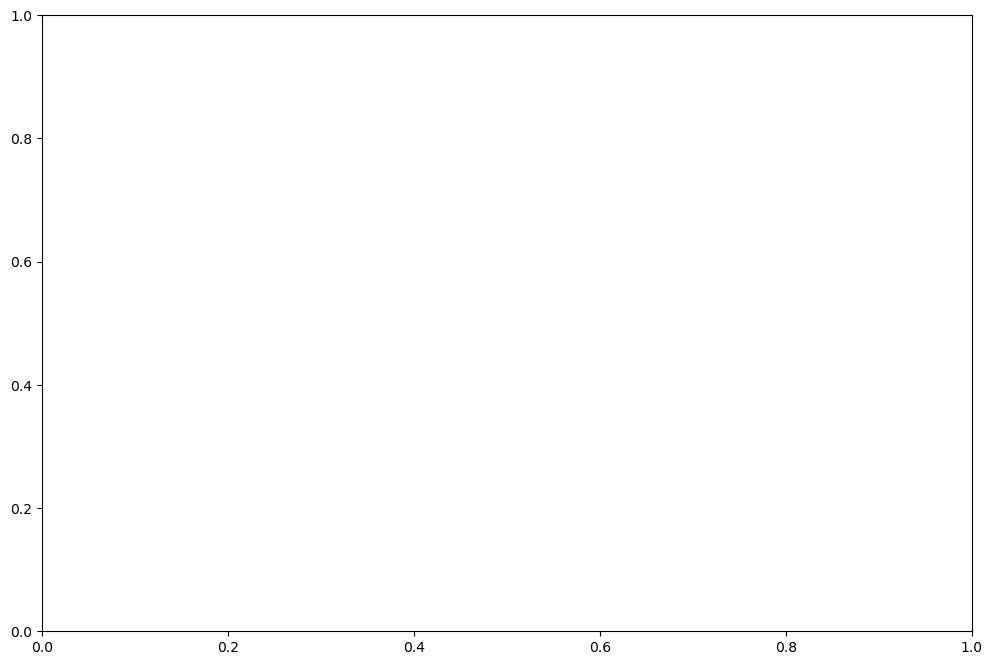

In [17]:
import pandas as pd
import cassiopeia as cas
import matplotlib.pyplot as plt

# Load your CassiopeiaTree object
# Assuming 'tree' is your loaded CassiopeiaTree
# tree = cas.data.CassiopeiaTree(tree=your_tree_data)

# Plot the tree with leaves oriented to the right and add a root for clarity
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size as needed
cas.pl.plot_matplotlib(tree, ax=ax, orient='right', add_root=True, show_leaf_labels=True)

plt.show()


In [21]:
tree.leaves

['L27.TCACAAGAGTTACGGG-1',
 'L27.TGGCCAGGTGGTTTCA-1',
 'L27.CTAAGACGTGACTCAT-1',
 'L27.ACTGTCCAGCGATATA-1',
 'L27.ACGCAGCCACCCATTC-1',
 'L27.TCAGCAAAGCTAACTC-1',
 'L27.CGACCTTTCTGGCGAC-1',
 'L27.CAGTCCTGTTAGGGTG-1',
 'L27.GCCAAATTCTCGCTTG-1',
 'L27.CATTATCTCGCCTGTT-1',
 'L27.AGCGGTCTCTACTATC-1',
 'L27.CATCGGGTCCTCAACC-1',
 'L27.TACTTGTAGCCAGTTT-1',
 'L27.AGGGAGTTCATGTGGT-1',
 'L27.AGGTCATGTTAGGGTG-1',
 'L27.GATGCTATCCTCATTA-1',
 'L27.ATGCGATCATGCGCAC-1',
 'L27.ACAGCCGTCAATAAGG-1',
 'L27.TCAGCAATCAGCAACT-1',
 'L27.GTACTCCCATTAGGCT-1',
 'L27.GAATAAGGTTTGTTTC-1',
 'L27.CTCACACTCATGTAGC-1',
 'L27.AATCGGTAGCCTCGTG-1',
 'L27.CACATTTCATTCTTAC-1',
 'L27.TGCGCAGCATCGGGTC-1',
 'L27.CCACCTAGTATTAGCC-1',
 'L27.ACGCAGCAGACTAGAT-1',
 'L27.CATTATCCATCACGTA-1',
 'L27.GTTACAGTCGGCTTGG-1',
 'L27.CGACTTCCAGGGTTAG-1',
 'L27.ACACCAACAGTGACAG-1']

In [19]:
df = compute_phylogenetic_weight_matrix(tree)


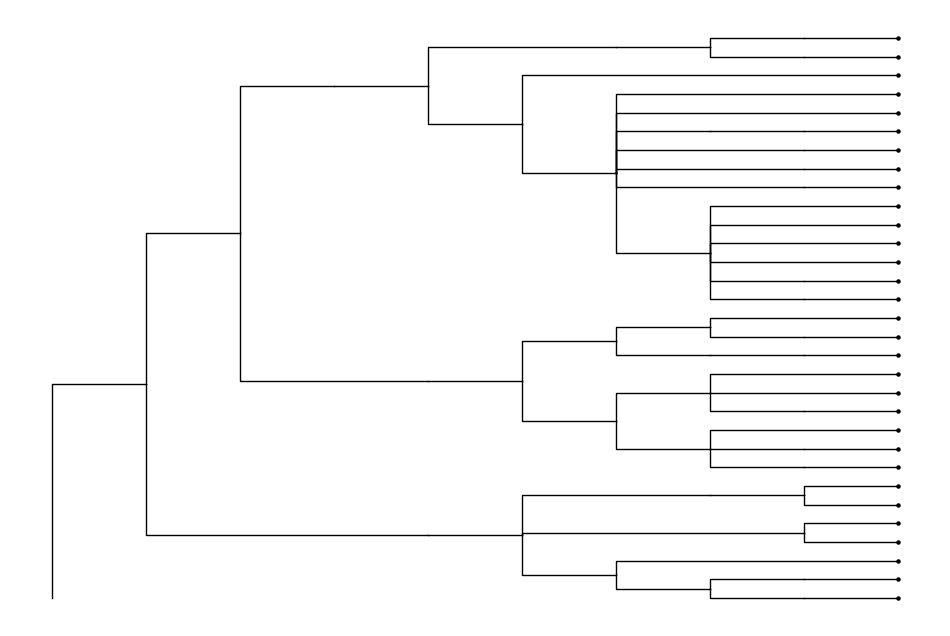

In [24]:
import pandas as pd
import cassiopeia as cas
import matplotlib.pyplot as plt

# Load your CassiopeiaTree object
# tree = cas.data.CassiopeiaTree(tree=your_tree_data)

# Plot the tree
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size as needed
cas.pl.plot_matplotlib(tree, ax=ax, orient='right', add_root=True, extend_branches=True)

plt.show()


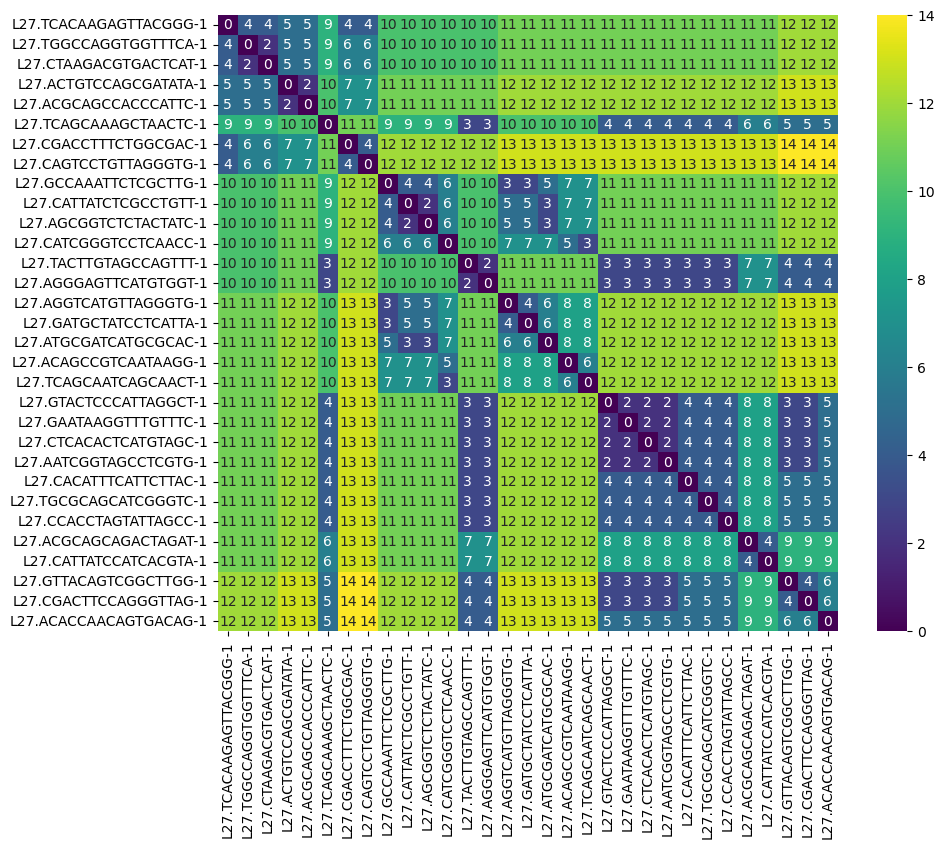

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your computed phylogenetic weight matrix
# df = compute_phylogenetic_weight_matrix(tree)

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(df, annot=True, cmap='viridis')  # 'annot' to annotate cells, 'cmap' for color map

plt.show()

In [35]:
tree.nodes

['cassiopeia_internal_node0',
 'cassiopeia_internal_node1',
 'cassiopeia_internal_node2',
 'cassiopeia_internal_node3',
 'cassiopeia_internal_node4',
 'cassiopeia_internal_node5',
 'cassiopeia_internal_node6',
 'cassiopeia_internal_node7',
 'cassiopeia_internal_node8',
 'cassiopeia_internal_node9',
 'cassiopeia_internal_node10',
 'cassiopeia_internal_node11',
 'L27.TCACAAGAGTTACGGG-1',
 'L27.TGGCCAGGTGGTTTCA-1',
 'L27.CTAAGACGTGACTCAT-1',
 'cassiopeia_internal_node12',
 'cassiopeia_internal_node13',
 'cassiopeia_internal_node14',
 'cassiopeia_internal_node15',
 'cassiopeia_internal_node16',
 'cassiopeia_internal_node17',
 'cassiopeia_internal_node18',
 'L27.ACTGTCCAGCGATATA-1',
 'L27.ACGCAGCCACCCATTC-1',
 'cassiopeia_internal_node19',
 'cassiopeia_internal_node20',
 'cassiopeia_internal_node21',
 'cassiopeia_internal_node22',
 'cassiopeia_internal_node23',
 'L27.TCAGCAAAGCTAACTC-1',
 'cassiopeia_internal_node24',
 'L27.CGACCTTTCTGGCGAC-1',
 'L27.CAGTCCTGTTAGGGTG-1',
 'cassiopeia_intern

In [40]:
# Convert tree to linkage matrix (assuming tree is in Newick format)
from scipy.cluster.hierarchy import linkage
from ete3 import Tree

newick_str = tree.get_newick()
ete_tree = Tree(newick_str)
linkage_matrix = ete_tree.linkage_matrix

# Determine your cutoff height for clustering
cutoff_height = 0.5  # adjust this value based on your analysis needs

# Perform clustering
clusters = fcluster(linkage_matrix, cutoff_height, criterion='distance')

# Group leaves by their clusters
cluster_groups = defaultdict(list)
for leaf, cluster_id in zip(ete_tree.get_leaf_names(), clusters):
    cluster_groups[cluster_id].append(leaf)

AttributeError: 'TreeNode' object has no attribute 'linkage_matrix'